## Bring in libraries and dataframes and set indexes

In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
import plotly.plotly as py
py.sign_in(username='HamishBrown', api_key='hAEIHQ5El6DxUXYNhzmg')
from plotly.graph_objs import *
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import matplotlib.dates as mdates

In [3]:
WaterDelta = pd.read_pickle('.\DataFrames\ProfileWaterDelta.pkl')

## investigate how much upward flux we are getting at night

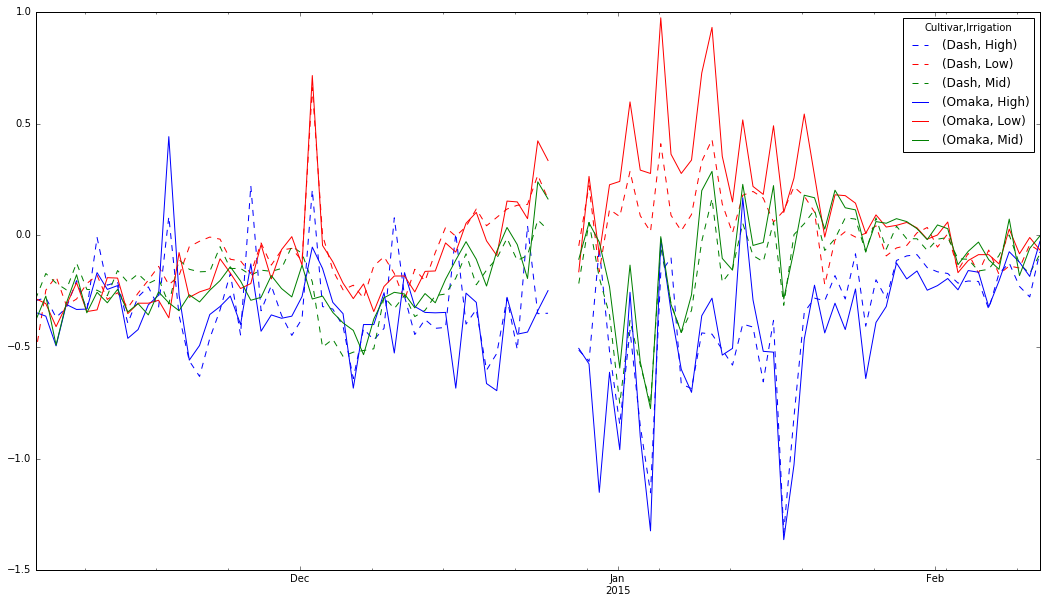

In [4]:
DarkWaterDeltas = WaterDelta.ix[WaterDelta.index.indexer_between_time(datetime.time(23),datetime.time(4))]
DarkWaterDeltas = DarkWaterDeltas.resample('24H', base=5).sum()#Base of 5 means sampling from 6am to 6am
MeanDarkWaterDeltas = DarkWaterDeltas.groupby(level=['Cultivar','Irrigation'],axis=1).mean()
MeanDarkWaterDeltas.plot( figsize=(18,10), style=['b--','r--','g--','b-','r-','g-'])

## Work out Irrigation timings and amounts.

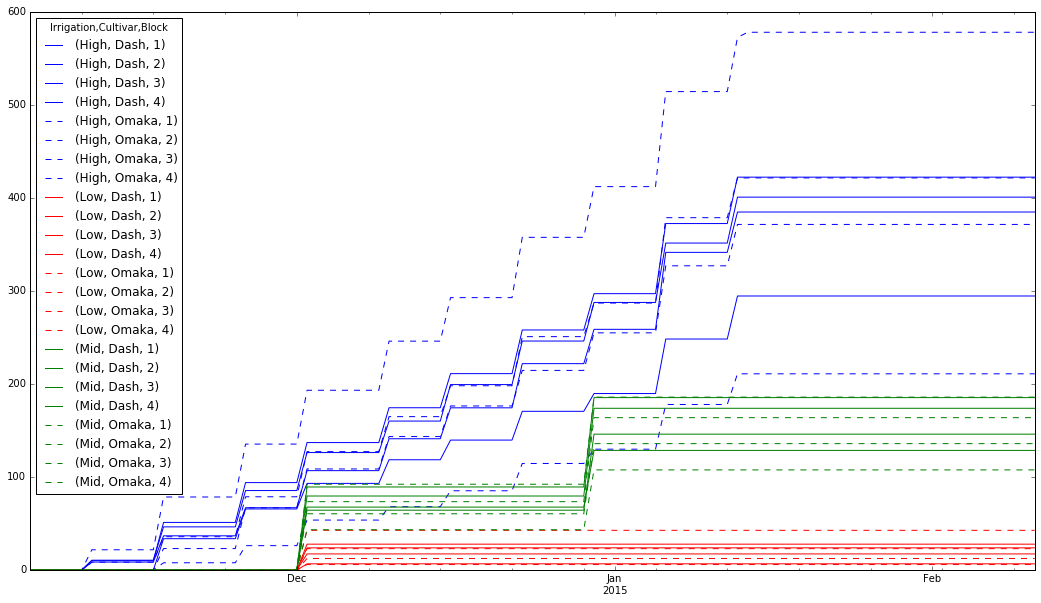

In [5]:
Irrigation = WaterDelta.where(WaterDelta > 3)
Irrigation = Irrigation.resample('D').sum()
Irrigation.fillna(0, inplace = True)
AccumIrrig = Irrigation.cumsum()
AccumIrrig.plot( figsize=(18,10), style=['b-','b-','b-','b-','b--','b--','b--','b--','r-','r-','r-','r-','r--','r--','r--','r--','g-','g-','g-','g-','g--','g--','g--','g--'])

In [6]:
DSIyesterday = 0

DaysSinceIrrigation = pd.DataFrame(index = Irrigation.index, columns = Irrigation.columns)
for col in DaysSinceIrrigation.columns:
    for x in range(Irrigation.index.size):
        if x == 0:
            DaysSinceIrrigation.ix[x,col] = float(0)
        else: 
            if Irrigation.ix[x,col] == 0:
                DaysSinceIrrigation.ix[x,col] = float(DaysSinceIrrigation.ix[x-1,col]+1)
            else:
                DaysSinceIrrigation.ix[x,col] = float(0)

## Whats causing the big negatives in the irrigated treatments, is it drainage following irrigation or dark water extraction following high ET day or night time transpiration??

### Bring in some variables that may explain it

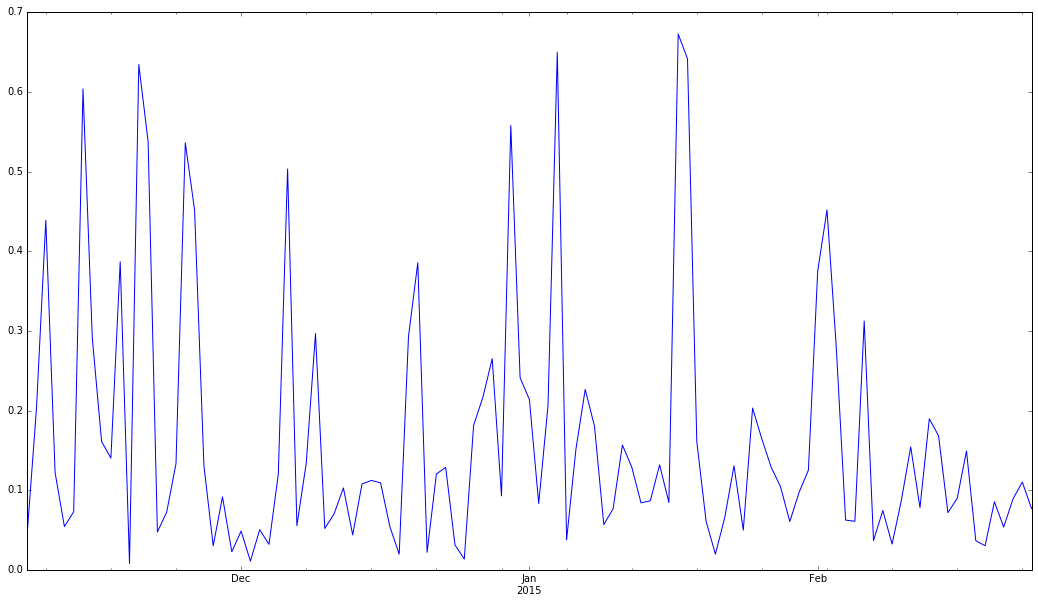

In [7]:
#Bring in night time PET data
NightTimePETAtmospheric = pd.read_pickle('.\DataFrames\NightTimePET.pkl')
NightTimePETAtmospheric.index = NightTimePETAtmospheric.index.normalize()
NightTimePETAtmospheric = NightTimePETAtmospheric.ix['2014-11-08':] #Drop of the first day because it only has a part nights numbers and no day associated wit it
NightTimePETAtmospheric.plot(figsize=(18,10))

In [8]:
NightTimeSoilHeatFlux = pd.read_pickle('.\DataFrames\SoilHeatFluxNightEst.pkl')
NightTimeSoilHeatFlux_mm = np.divide(NightTimeSoilHeatFlux,2.4)

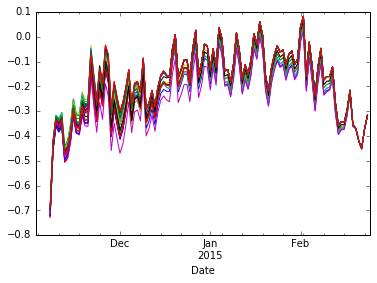

In [9]:
NightTimeSoilHeatFlux_mm.plot(legend=False)

In [10]:
DayTimePET = pd.read_pickle('.\DataFrames\DayTimePET.pkl')
DayTimePET.index = DayTimePET.index.normalize()

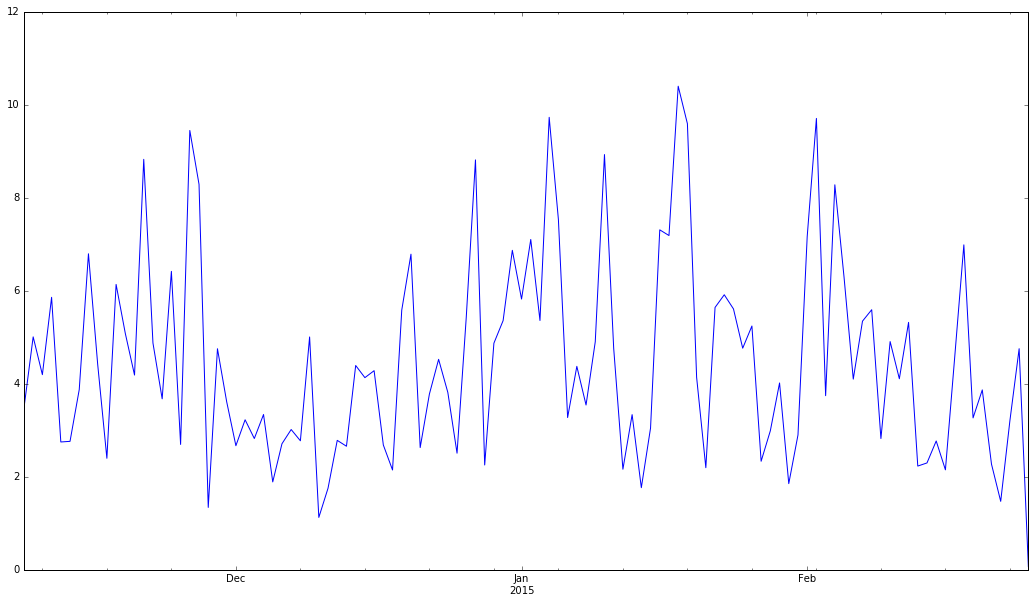

In [11]:
DayTimePET.plot(figsize=(18,10))

## Stick the Dark water delta into a data frame with the things that might explain it and do a multiple regression

In [12]:
SWD = pd.read_pickle('.\DataFrames\DailySWD.pkl')

In [13]:
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'Mid','High']

LongData = MeanDarkWaterDeltas.ix['2014-11-08':,:]
LongData.index = LongData.index.normalize()
LongData = LongData.unstack()
LongData = pd.DataFrame(LongData, columns=['DarkDeltas'])
#multiply Gnight by -1 to make positive (potential evaporation as apposed to negative heat gain)
LongData.ix[:,'Gnight'] = NightTimeSoilHeatFlux_mm.ix['2014-11-08':'2015-02-11',:].groupby(level=('Cultivar','Irrigation'),axis=1).mean().unstack().multiply(-1)
LongData.ix[:,'SWD'] = SWD.ix['2014-11-08':'2015-02-11',:].groupby(level=('Cultivar','Irrigation'),axis=1).mean().unstack()
for Cult in Cultivars:
    for Irr in Irrigations:
        LongData.ix[(Cult,Irr),'PETAtmoNight'] = NightTimePETAtmospheric.ix['2014-11-08':'2015-02-11'].values
        LongData.ix[(Cult,Irr),'PETAtmoDay'] = DayTimePET.ix['2014-11-08':'2015-02-11'].values
        LongData.ix[(Cult,Irr),'DSI'] = DaysSinceIrrigation.ix['2014-11-08':'2015-02-11',(Irr,Cult)].mean(axis=1).values
LongData.ix[:,'PETnight'] = LongData.ix[:,'Gnight']+LongData.ix[:,'PETAtmoNight']
LongData.ix[:,'IntSWD_PETnight'] = LongData.ix[:,'SWD']*LongData.ix[:,'PETnight']
LongData.ix[:,'IntSWD_Gnight'] = LongData.ix[:,'SWD']*LongData.ix[:,'Gnight']
LongData.ix[:,'IntSWD_PETAtmoNight'] = LongData.ix[:,'SWD']*LongData.ix[:,'PETAtmoNight']
LongData.ix[:,'IntSWD_PETDay'] = LongData.ix[:,'SWD']*LongData.ix[:,'PETAtmoDay']

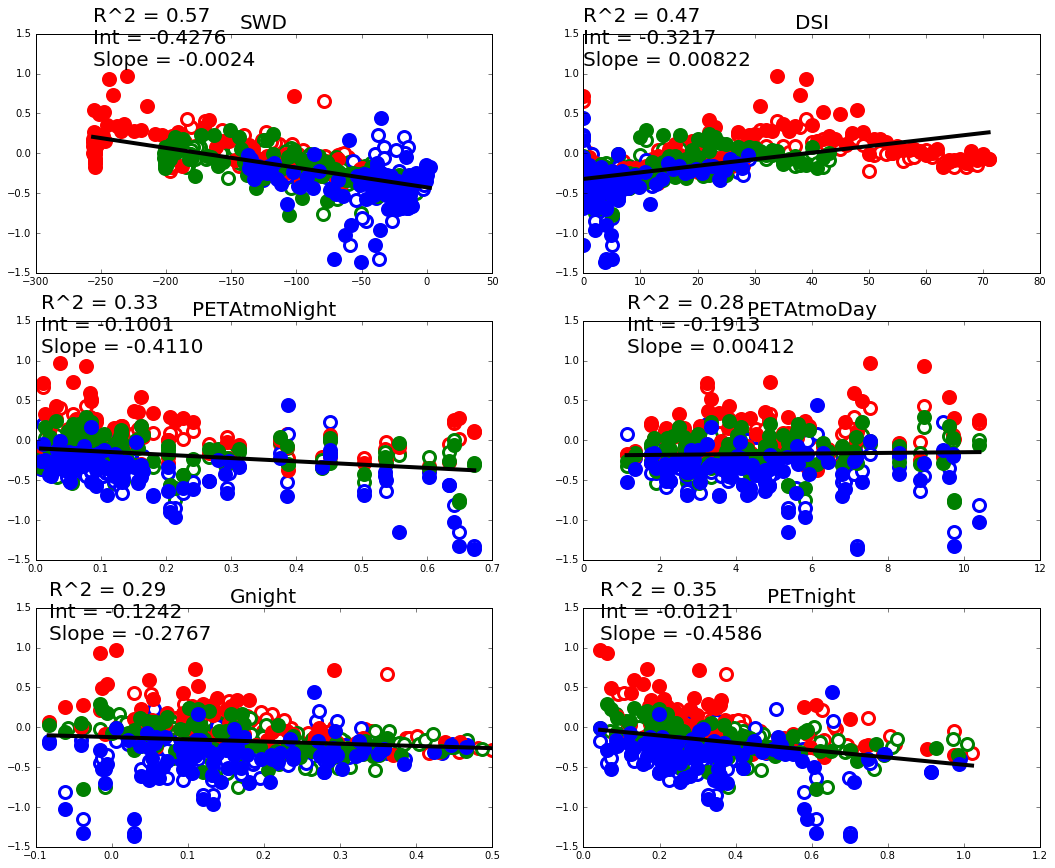

In [14]:
Graph = plt.figure(figsize=(18,30))
plt.figure(figsize=(18,10))
ecols = ['r','g','b','r','g','b']
fcols = ['w','w','w','r','g','b']
pannel = 1
Descriptors = [ 'SWD', 'DSI', 'PETAtmoNight','PETAtmoDay','Gnight','PETnight']
for des in Descriptors:
    DailyDescriptor = LongData.ix[:,des]
    fig = Graph.add_subplot(6,2,pannel)
    pos = 0
    for cul in Cultivars:
        for irr in Irrigations:
            fig.plot(LongData.ix[(cul,irr),des].ix['2014-11-08':],
                LongData.ix[(cul,irr),'DarkDeltas'].ix['2014-11-08':],
                     'o',mec=ecols[pos],mfc=fcols[pos],mew = 3, markersize = 12,)
            pos+=1  
    
    X = LongData.ix[:,LongData.columns.isin([des])]
    Y = LongData.ix[:,'DarkDeltas']
    ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                            sm.add_constant(X), # X variable
                                            missing='drop',                                     # ignor and data where one value is missing
                                            hasconst=False) 
    Regres = ModTemp.fit(); 
    Xs = []
    Xs.append(X.min())
    Xs.append(X.max())
    Ys = []
    Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
    Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
    fig.plot(Xs,Ys,'-', linewidth = 4, color='k')
    fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\nInt = ' + str(Regres.params[0])[:7] + '\nSlope = ' + str(Regres.params[1])[:7]
    fig.text(X.min(),1.1,fitR2,fontsize=20)
    fig.set_ylim(-1.5,1.5)
    fig.set_title(des, fontsize = 20)
    pannel +=1

In [15]:
Descriptors = ['SWD']
X = LongData.ix[:,LongData.columns.isin(Descriptors)]
Y = LongData.ix[:,'DarkDeltas']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             DarkDeltas   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     378.1
Date:                Tue, 26 Jun 2018   Prob (F-statistic):          9.18e-105
Time:                        11:26:03   Log-Likelihood:                 76.335
No. Observations:                 564   AIC:                            -148.7
Df Residuals:                     562   BIC:                            -140.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.4276      0.016    -27.055      0.000        -0.459    -0.397
SWD           -0.0025      0.000    -19.564      0.000        -0.003    -0.002
==============================================================================
Omnibus:                       91.686   Durbin-Watson:                   1.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              715.049
Skew:                          -0.442   Prob(JB):                    5.36e-156
Kurtosis:                       8.445   Cond. No.                         222.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
Descriptors = ['SWD','PETAtmoday']
X = LongData.ix[:,LongData.columns.isin(Descriptors)]
Y = LongData.ix[:,'DarkDeltas']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Regres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             DarkDeltas   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     378.1
Date:                Tue, 26 Jun 2018   Prob (F-statistic):          9.18e-105
Time:                        11:26:03   Log-Likelihood:                 76.335
No. Observations:                 564   AIC:                            -148.7
Df Residuals:                     562   BIC:                            -140.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.4276      0.016    -27.055      0.000        -0.459    -0.397
SWD           -0.0025      0.000    -19.564      0.000        -0.003    -0.002
==============================================================================
Omnibus:                       91.686   Durbin-Watson:                   1.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              715.049
Skew:                          -0.442   Prob(JB):                    5.36e-156
Kurtosis:                       8.445   Cond. No.                         222.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Some things are clear from first glance.  SWD is having a strong influence on dark water deltas.  this makes sense because when the soil is wet there will be flux below out of the bottom and when it is dry there into the bottom of the profile.  So a large part of the dark water deltas can be attributed to unsaturated fluxes over the bottom of the profile.  Assumably these will be the same at day as they are at night and need to be accounted for in the water balance.
### There is a relationship between SWD and DSI.  Lets investigate that further

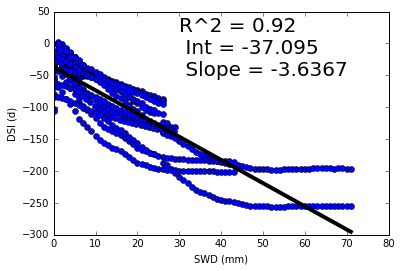

In [17]:
X = LongData.ix[:,'DSI'].ix['2014-11-08':]
Y = LongData.ix[:,'SWD'].ix['2014-11-08':]
plt.plot(X,Y,'o')

ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
plt.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
plt.text(30,-50,fitR2,fontsize=20)
plt.xlabel('SWD (mm)')
plt.ylabel('DSI (d)')

## SWD and DSI are highly correlated so it is the SWD that is causing the relationship between DSI and dark water deltas.  Some non-linearity between dark water deltas and DSI would indicate saturated drainage, dropping away soon after irrigation but this was not apparent so we can not attribute any of the dark water deltas to drainage. 

## There were also positive effects from darkPETatmo and Gdark (and the sum of these, PETnight).  Lets take a closer look at them

In [18]:
#Calculate residuals from SWD relationship and look at how well other things explain
LongData.ix[:,'EstDarkDeltas'] = -0.427 + LongData.ix[:,'SWD'] * -0.0024
LongData.ix[:,'ResDarkDeltas'] = LongData.ix[:,'DarkDeltas'] - LongData.ix[:,'EstDarkDeltas']

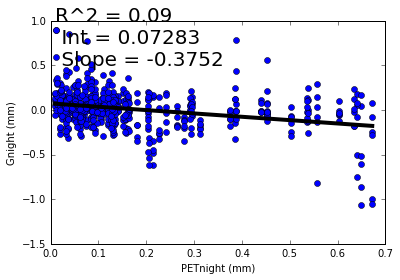

In [19]:
X = LongData.ix[:,'PETAtmoNight'].ix['2014-11-08':]
Y = LongData.ix[:,'ResDarkDeltas'].ix['2014-11-08':]
plt.plot(X,Y,'o')

ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
plt.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
plt.text(X.min(),0.5,fitR2,fontsize=20)
plt.xlabel('PETnight (mm)')
plt.ylabel('Gnight (mm)')

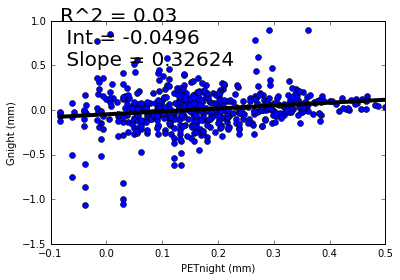

In [20]:
X = LongData.ix[:,'Gnight'].ix['2014-11-08':]
Y = LongData.ix[:,'ResDarkDeltas'].ix['2014-11-08':]
plt.plot(X,Y,'o')

ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
plt.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
plt.text(X.min(),0.5,fitR2,fontsize=20)
plt.xlabel('PETnight (mm)')
plt.ylabel('Gnight (mm)')

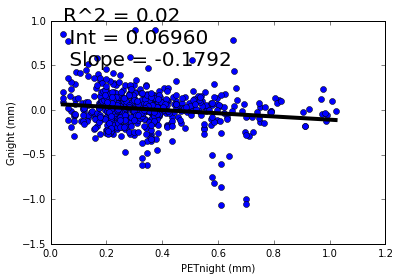

In [21]:
X = LongData.ix[:,'PETnight'].ix['2014-11-08':]
Y = LongData.ix[:,'ResDarkDeltas'].ix['2014-11-08':]
plt.plot(X,Y,'o')

ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
plt.plot(Xs,Ys,'-', linewidth = 4, color='k')
fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
plt.text(X.min(),0.5,fitR2,fontsize=20)
plt.xlabel('PETnight (mm)')
plt.ylabel('Gnight (mm)')

In [22]:
UpwardFlux = DarkWaterDeltas.copy()
UpwardFlux.index = UpwardFlux.index.normalize()
for plot in  UpwardFlux:
    AdjustedFlux = UpwardFlux.ix[:,plot].values
    AdjustedFlux = np.add(AdjustedFlux,NightTimePETAtmospheric.ix[UpwardFlux.index].values) # Add in the amount of evaporation that would have been replaced
    #AdjustedFlux = np.subtract(AdjustedFlux,NightTimeSoilHeatFlux_mm.ix[UpwardFlux.index,plot].fillna(0))
    UpwardFlux.ix[:,plot] = AdjustedFlux
UpwardFlux = UpwardFlux.multiply(4)  # Multiply by 4 assuming upflux during the day were the same as at night
UpwardFlux.fillna(0, inplace = True)
MeanUpwardFlux = UpwardFlux.groupby(level=['Irrigation', 'Cultivar'],axis=1).mean()
#MeanUpwardFlux.plot( figsize=(18,10), style=['b-','b--','r-','r--','g-','g--'])
#UpwardFlux.plot( figsize=(18,10), style=['b-','b-','b-','b-','b--','b--','b--','b--','r-','r-','r-','r-','r--','r--','r--','r--','g-','g-','g-','g-','g--','g--','g--','g--'])
HighDash = Scatter(x=MeanUpwardFlux.index, y=MeanUpwardFlux.ix[:,('High','Dash')].values,
                   name = 'High Dash',line = Line(color='blue',dash='dash') )
MidDash = Scatter(x=MeanUpwardFlux.index, y=MeanUpwardFlux.ix[:,('Mid','Dash')],
                   name = 'Mid Dash',line = Line(color='green',dash='dash') )
LowDash = Scatter(x=MeanUpwardFlux.index, y=MeanUpwardFlux.ix[:,('Low','Dash')],
                   name = 'Low Dash',line = Line(color='red',dash='dash') )
HighOmaka = Scatter(x=MeanUpwardFlux.index, y=MeanUpwardFlux.ix[:,('High','Omaka')],
                   name = 'High Omaka',line = Line(color='blue',dash='solid') )
MidOmaka = Scatter(x=MeanUpwardFlux.index, y=MeanUpwardFlux.ix[:,('Mid','Omaka')],
                   name = 'Mid Omaka',line = Line(color='green',dash='solid') )
LowOmaka = Scatter(x=MeanUpwardFlux.index, y=MeanUpwardFlux.ix[:,('Low','Omaka')],
                   name = 'Low Omaka',line = Line(color='red',dash='solid') )
data = Data([HighDash, MidDash, LowDash, HighOmaka, MidOmaka, LowOmaka])
py.iplot(data,filename='basic-line')

### Thiss give a sensible pattern of fluxes where then are about 1 at the start of the trial and become progressively higher for the Low and more negative for the Full treatments as time progresses

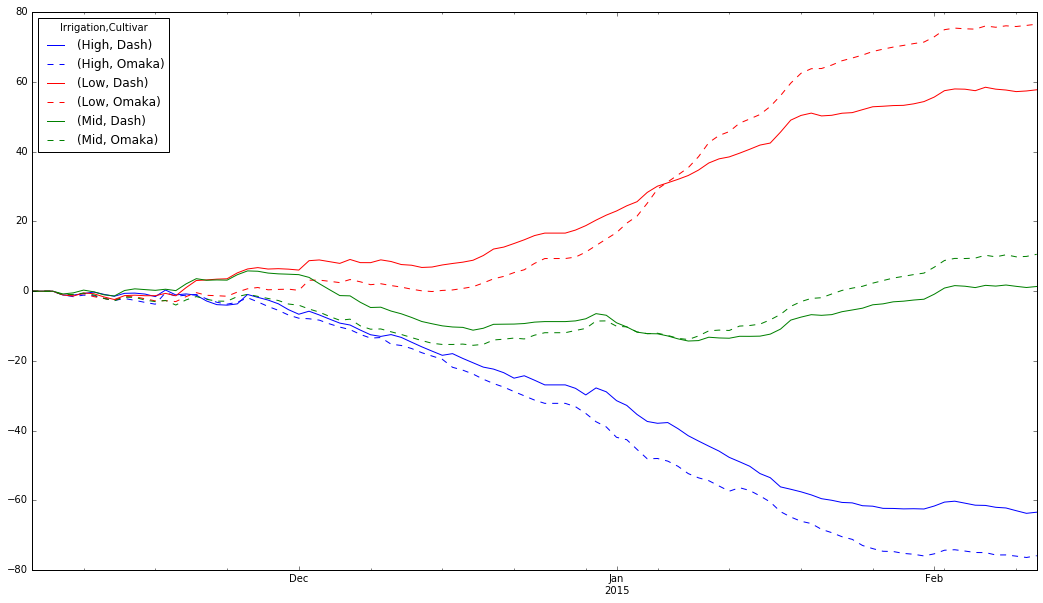

In [23]:
AccumUpFlux = MeanUpwardFlux.cumsum()
AccumUpFlux.plot( figsize=(18,10),style=['b-','b--','r-','r--','g-','g--'])#ylim = (-1,17),

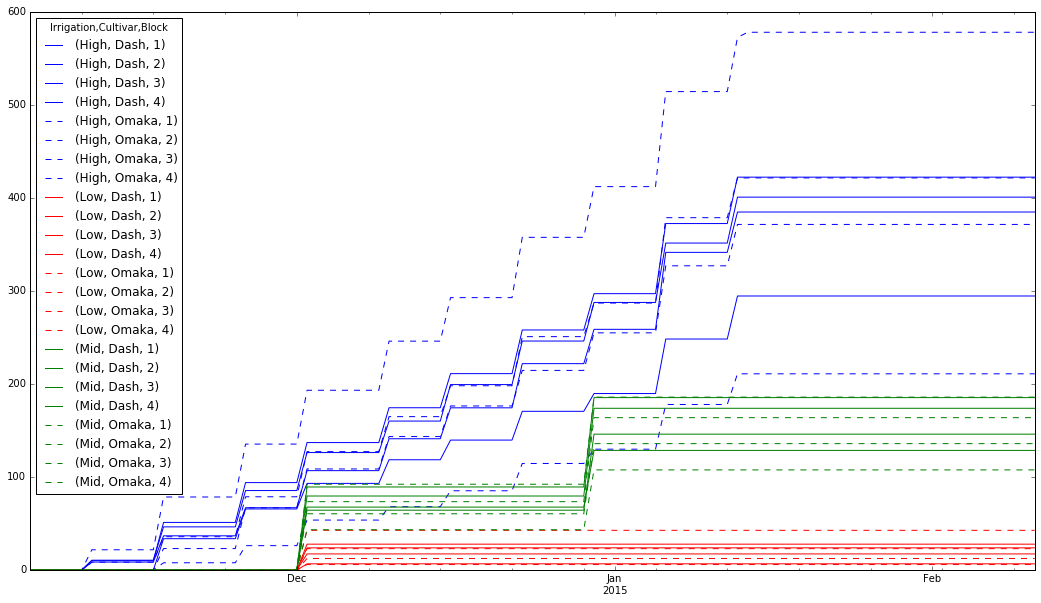

In [24]:
Irrigation = WaterDelta.where(WaterDelta > 3)
Irrigation = Irrigation.resample('D').sum()
Irrigation.fillna(0, inplace = True)
AccumIrrig = Irrigation.cumsum()
AccumIrrig.plot( figsize=(18,10), style=['b-','b-','b-','b-','b--','b--','b--','b--','r-','r-','r-','r-','r--','r--','r--','r--','g-','g-','g-','g-','g--','g--','g--','g--'])

In [25]:
Irrigation.to_pickle('.\DataFrames\Irrigation.pkl')

In [26]:
HighIrrigIndex = Irrigation.where(Irrigation > 0).dropna(how='all').index.tolist()
del HighIrrigIndex[-1:]

In [27]:
HighIrrigIndex

[Timestamp('2014-11-11 00:00:00'),
 Timestamp('2014-11-18 00:00:00'),
 Timestamp('2014-11-26 00:00:00'),
 Timestamp('2014-12-02 00:00:00'),
 Timestamp('2014-12-10 00:00:00'),
 Timestamp('2014-12-16 00:00:00'),
 Timestamp('2014-12-23 00:00:00'),
 Timestamp('2014-12-30 00:00:00'),
 Timestamp('2015-01-06 00:00:00'),
 Timestamp('2015-01-13 00:00:00')]

In [28]:
LowIrrIndex = ('2014-12-02 00:00:00')
MidIrrIndex = ['2014-12-02 00:00:00','2014-12-23 00:00:00']
HighIrrigIndex = ['2014-11-11 00:00:00',
 '2014-11-18 00:00:00',
 '2014-11-26 00:00:00',
 '2014-12-02 00:00:00',
 '2014-12-10 00:00:00',
 '2014-12-16 00:00:00',
 '2014-12-23 00:00:00',
 '2014-12-30 00:00:00',
 '2015-01-06 00:00:00',
 '2015-01-14 00:00:00']

In [29]:
HighIrrigIndex

['2014-11-11 00:00:00',
 '2014-11-18 00:00:00',
 '2014-11-26 00:00:00',
 '2014-12-02 00:00:00',
 '2014-12-10 00:00:00',
 '2014-12-16 00:00:00',
 '2014-12-23 00:00:00',
 '2014-12-30 00:00:00',
 '2015-01-06 00:00:00',
 '2015-01-14 00:00:00']

# Calculate hourly water use values

## Calculate profile water content deltas for each 1 hour measurement period

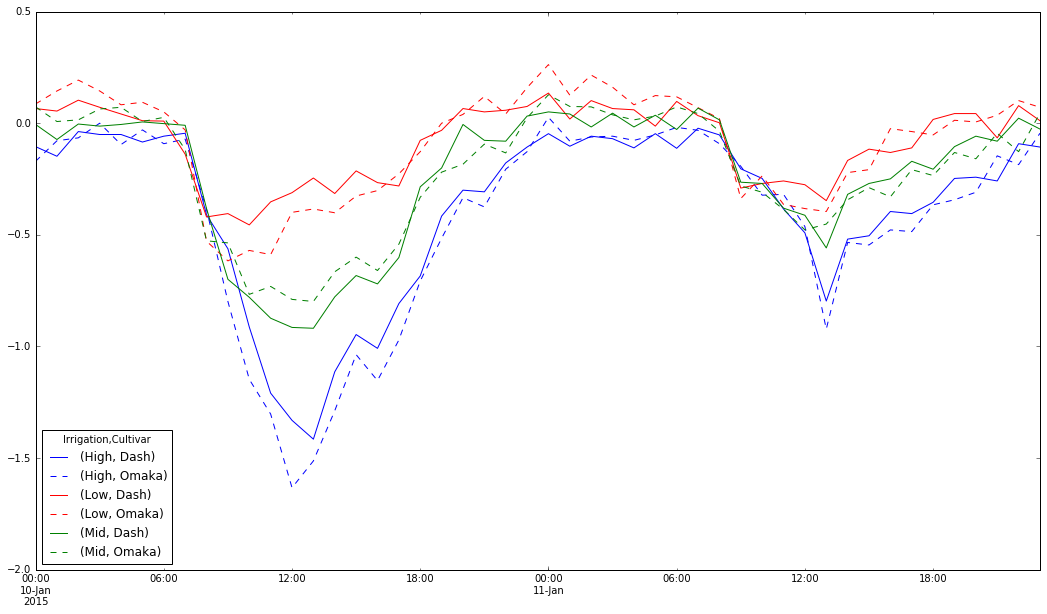

In [30]:
#WaterDelta = ProfileWater2.diff()
WaterDeltaHourly = WaterDelta.resample('h').sum()
#WaterUseHourly['2015-01-03':'2015-01-20'].plot(ylim = (-3,2), legend = False, figsize=(18,18),style=['b-','b-','b-','b-','b--','b--','b--','b--','r-','r-','r-','r-','r--','r--','r--','r--','g-','g-','g-','g-','g--','g--','g--','g--'])
MeanWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation', 'Cultivar'],axis=1).mean()
SEMWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation', 'Cultivar'],axis=1).std()/np.sqrt(4)
MeanWaterDeltaHourly.ix['2015-01-10':'2015-01-11'].plot(figsize=(18,10),style=['b-','b--','r-','r--','g-','g--'], ylim=(-2,0.5))



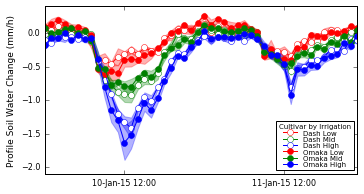

In [54]:
WaterDeltaHourly = WaterDelta.resample('h').sum()
MeanWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation', 'Cultivar'],axis=1).mean()
SEMWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation', 'Cultivar'],axis=1).std()/np.sqrt(4)
Start = '2015-01-10'
End = '2015-01-11'
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'Mid', 'High']
colors = ['r','b']
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
alphas = [0.2,0.3]
fig, ax = plt.subplots(figsize=(5.6,3))
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = MeanWaterDeltaHourly.ix[Start:End,(Irr,Cul)].index
        Med = MeanWaterDeltaHourly.ix[Start:End,(Irr,Cul)]
        SEM = SEMWaterDeltaHourly.ix[Start:End,(Irr,Cul)]
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = irrigColors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o-',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr,color=irrigColors[IrrPos])
        IrrPos += 1
        CulPos+=1
        
plt.ylabel('Profile Soil Water Change (mm/h)',fontsize=9)
ax.xaxis.set_major_locator(mdates.HourLocator(12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y %H:%M'))
plt.tick_params(labelsize=8)
plt.ylim(-2.1,0.4)

ledg = plt.legend(loc=4,numpoints=1,fontsize = 7,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(7)
plt.savefig('Fig_#.jpg',dpi=1000)

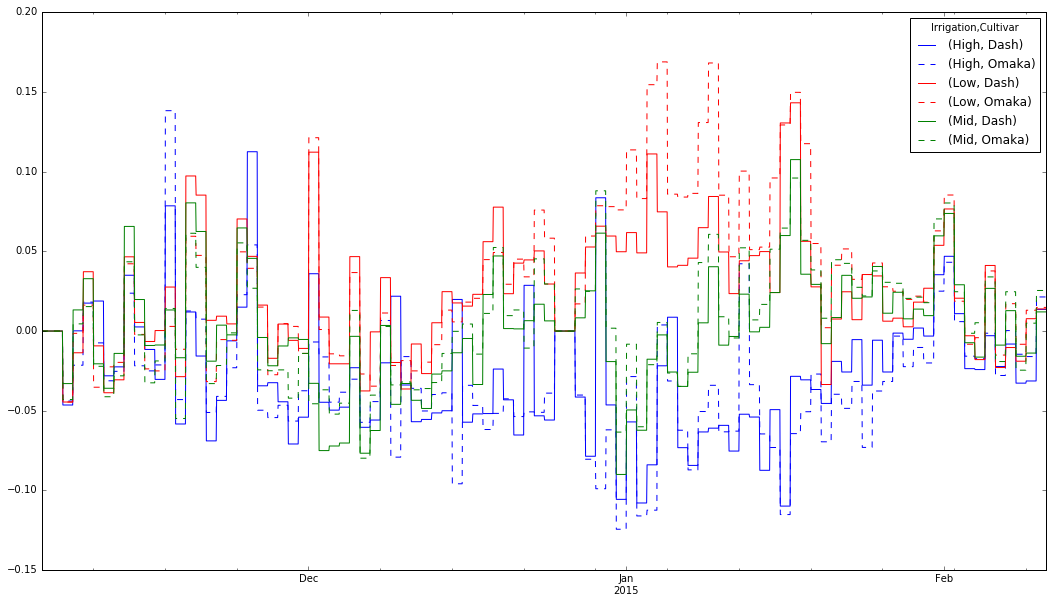

In [32]:
UpwardFluxHourlyArray = np.divide(UpwardFlux.values,24)
UpwardFluxHourly = pd.DataFrame(data = UpwardFluxHourlyArray,index=UpwardFlux.index,columns=UpwardFlux.columns)
UpwardFluxHourly = UpwardFluxHourly.resample('h').bfill()
MeanUpwardFluxHourly = UpwardFluxHourly.groupby(level=['Irrigation', 'Cultivar'],axis=1).mean()
MeanUpwardFluxHourly.plot( figsize=(18,10), style=['b-','b--','r-','r--','g-','g--'])

(-0.5, 0.2)

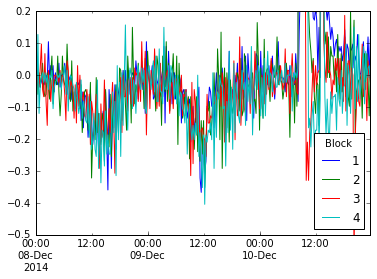

In [33]:
WaterDelta.ix['2014-12-08':'2014-12-10',('High','Omaka')].plot()
plt.ylim(-.5,.2)

(-0.5, 0.2)

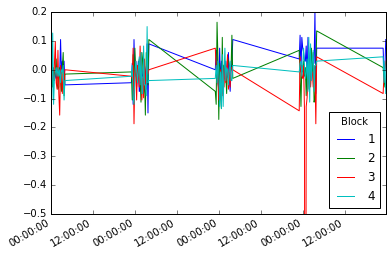

In [34]:
WaterDelta.ix[WaterDelta.index.indexer_between_time(datetime.time(23),datetime.time(4))].ix['2014-12-08':'2014-12-11',('High','Omaka')].plot()
plt.ylim(-.5,.2)

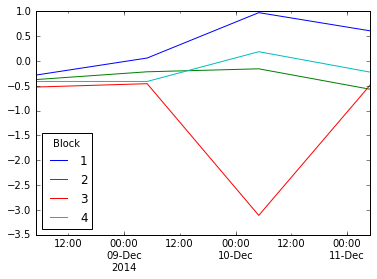

In [35]:
DarkWaterDeltas.ix['2014-12-08':'2014-12-11',('High','Omaka')].plot()
#plt.ylim(-.5,.2)

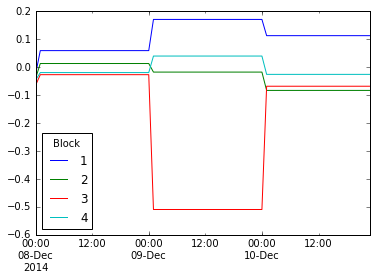

In [36]:
UpwardFluxHourly.ix['2014-12-08':'2014-12-10',('High','Omaka')].plot()

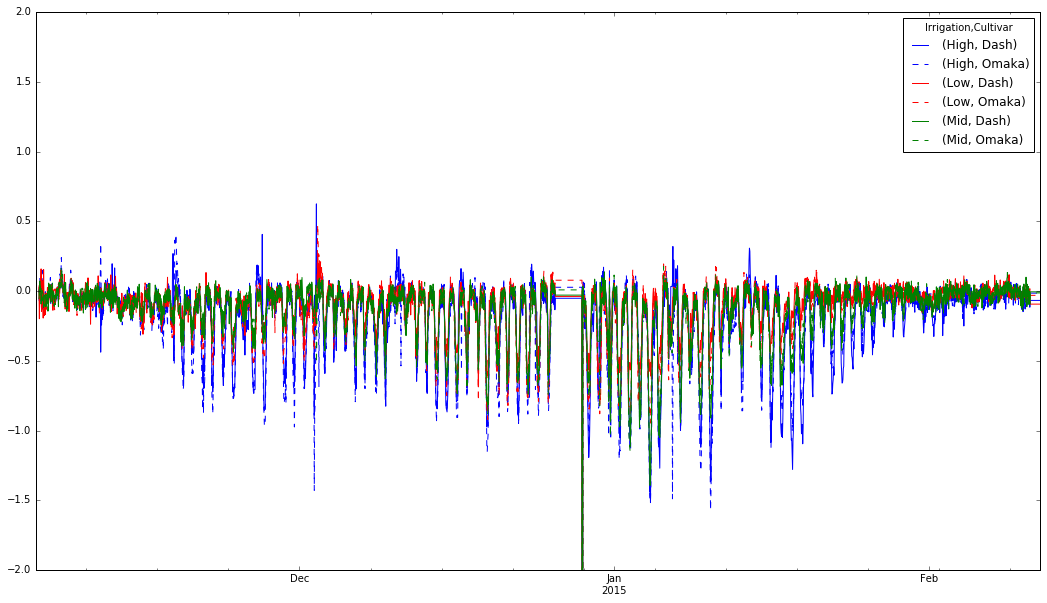

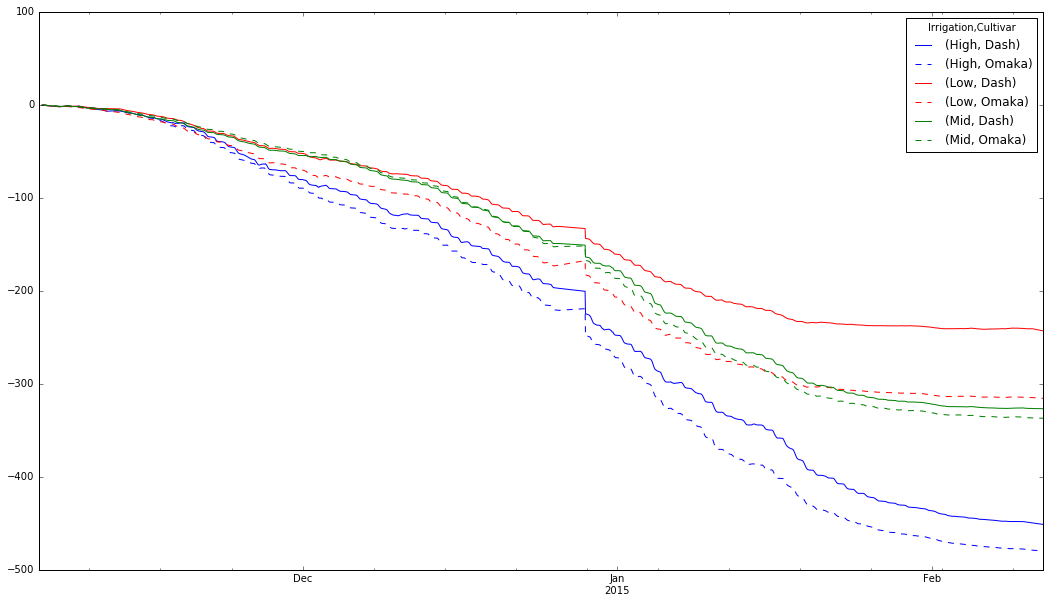

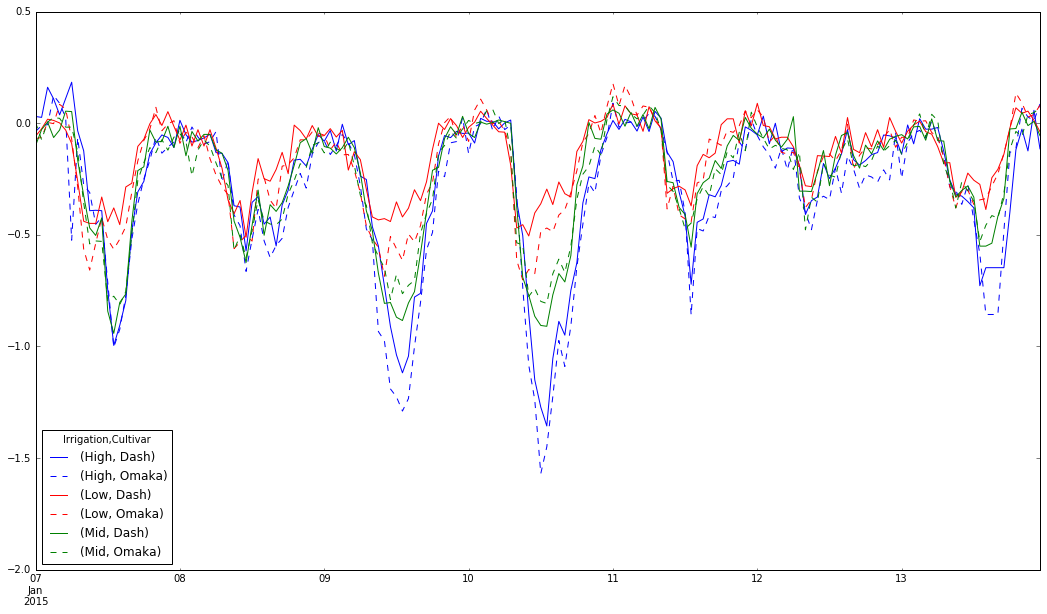

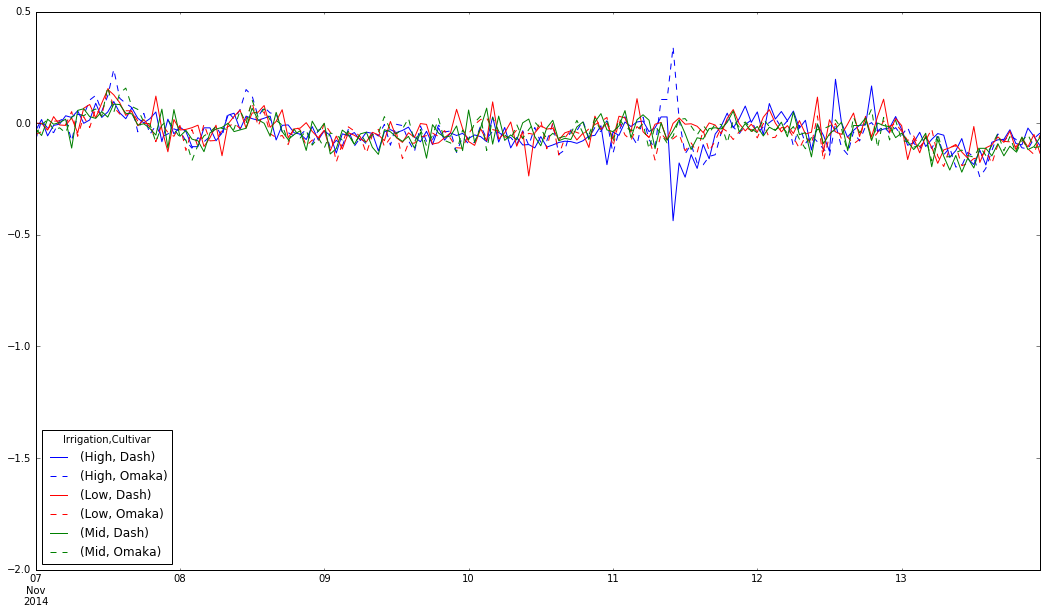

In [37]:
WaterUseHourly = WaterDeltaHourly.subtract(UpwardFluxHourly)
WaterUseHourly = WaterUseHourly.where(WaterUseHourly<1)
WaterUseHourly.fillna(method='ffill', inplace = True)
MeanWaterUseHourly = WaterUseHourly.groupby(level=['Irrigation', 'Cultivar'],axis=1).mean()
MeanWaterUseHourly.plot(figsize=(18,10),style=['b-','b--','r-','r--','g-','g--'], ylim=(-2,2))
MeanWaterUseHourly.cumsum().plot(figsize=(18,10),style=['b-','b--','r-','r--','g-','g--'])
MeanWaterUseHourly.ix['2015-01-07':'2015-01-13'].plot(figsize=(18,10),style=['b-','b--','r-','r--','g-','g--'], ylim=(-2,0.5))
MeanWaterUseHourly.ix['2014-11-07':'2014-11-13'].plot(figsize=(18,10),style=['b-','b--','r-','r--','g-','g--'], ylim=(-2,0.5))

In [38]:
WaterUseHourly.to_pickle('.\DataFrames\HourlyWUmm.pkl')

## Calculate Daily Water Use

In [39]:
#Set up daily water use sums
WaterUseDaily = WaterUseHourly.resample('D').sum()
WaterUseDaily.index.name = 'Date'

#Wipe the data on the days when the data logger was full
WaterUseDaily.ix['2014-12-26':'2014-12-28',:] = np.nan

#wipe the data on the days when irrigation occured 
WaterUseDaily.ix[LowIrrIndex,'Low']=np.nan
for date in MidIrrIndex:
    WaterUseDaily.ix[date,'Mid']=np.nan
for date in HighIrrigIndex:
    WaterUseDaily.ix[date,'High']=np.nan


In [40]:
#calculate treatment means
WaterUseDailyMeans = WaterUseDaily.groupby(level=['Irrigation', 'Cultivar'],axis=1).mean()
#Make water use positive
WaterUseDailyMeans = WaterUseDailyMeans.multiply(-1)
#Remove the 28th of December because data was lost from the previous two days meaning these days water use was moved into the 28th
WaterUseDailyMeans.ix['2014-12-25':'2014-12-28'] = np.nan

#plot results
#WaterUseDailyMeans.plot( figsize=(18,10),style=['b--','b-','r--','r-','g--','g-'])#ylim = (-1,17),
HighDash = Scatter(x=WaterUseDailyMeans.index, y=WaterUseDailyMeans.ix[:,('High','Dash')].values,
                   name = 'High Dash',line = Line(color='blue',dash='dash') )
MidDash = Scatter(x=WaterUseDailyMeans.index, y=WaterUseDailyMeans.ix[:,('Mid','Dash')],
                   name = 'Mid Dash',line = Line(color='green',dash='dash') )
LowDash = Scatter(x=WaterUseDailyMeans.index, y=WaterUseDailyMeans.ix[:,('Low','Dash')],
                   name = 'Low Dash',line = Line(color='red',dash='dash') )
HighOmaka = Scatter(x=WaterUseDailyMeans.index, y=WaterUseDailyMeans.ix[:,('High','Omaka')],
                   name = 'High Omaka',line = Line(color='blue',dash='solid') )
MidOmaka = Scatter(x=WaterUseDailyMeans.index, y=WaterUseDailyMeans.ix[:,('Mid','Omaka')],
                   name = 'Mid Omaka',line = Line(color='green',dash='solid') )
LowOmaka = Scatter(x=WaterUseDailyMeans.index, y=WaterUseDailyMeans.ix[:,('Low','Omaka')],
                   name = 'Low Omaka',line = Line(color='red',dash='solid') )
data = Data([HighDash, MidDash, LowDash, HighOmaka, MidOmaka, LowOmaka])
py.iplot(data,filename='basic-line')

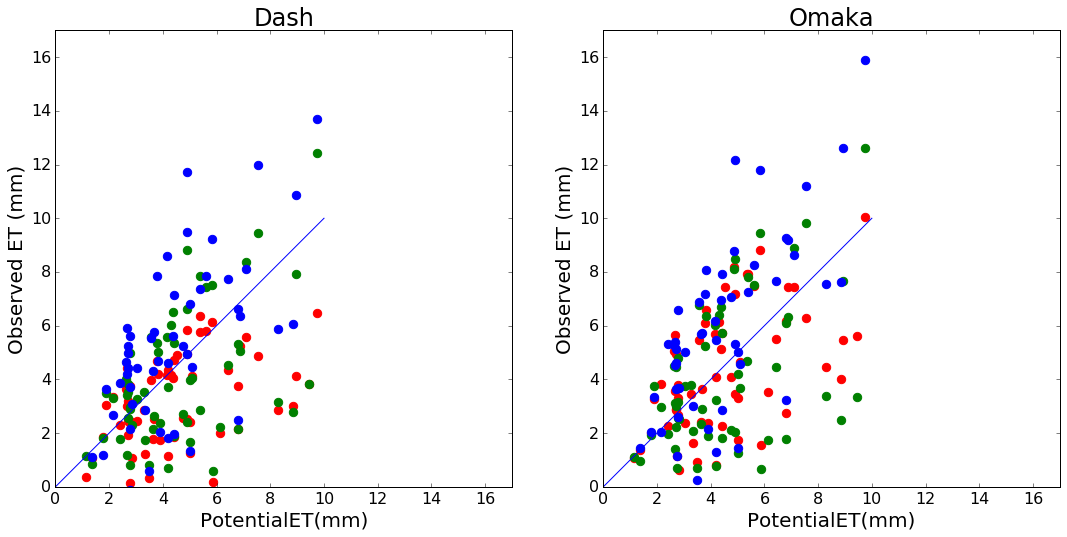

In [41]:
Comparison = plt.figure(figsize = (18,18))

Irrigations = ['Low','Mid','High']
Cultivars = ['Dash','Omaka']
Colors = ['red','green','blue']

Position = 1
for Cul in Cultivars:
    fig = Comparison.add_subplot(2,2,Position)
    ColorPosition = 0   
    for Irr in Irrigations:
        yData = WaterUseDailyMeans.ix['2014-11-08':'2015-01-10',(Irr,Cul)]
        plt.scatter(DayTimePET.ix['2014-11-08':'2015-01-10'],
                    yData, 
                    color = Colors[ColorPosition],
                    label = Irr,
                    s = 70)
        ColorPosition += 1
    plt.plot([0,10],[0,10],'-')
    plt.ylabel('Observed ET (mm)', fontsize= 20)
    plt.xlabel('PotentialET(mm)', fontsize= 20)
    plt.tick_params(labelsize = 16)
    plt.ylim(0,17)
    plt.xlim(0,17)
    #plt.legend(loc=1,fontsize = 24)
    plt.title(Cul, fontsize = 24)
    Position +=1

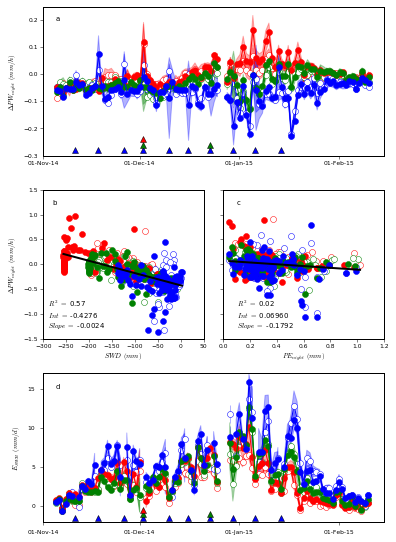

In [42]:
Graph = plt.figure(figsize=(5.6,10))

#Dark Water Delta graph
Cultivars = ['Dash','Omaka']
Irrigations = ['Low', 'Mid', 'High']
colors = ['r','b']
cultColors = ['w','w','w','r','g','b']
irrigColors = ['r','g','b','r','g','b']
alphas = [0.2,0.3]
fig = plt.subplot2grid((4,2),(0,0),colspan=2)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = DarkWaterDeltas.ix[:'2015-02-10',(Irr,Cul)].index
        Med = DarkWaterDeltas.ix[:'2015-02-10',(Irr,Cul)].mean(axis=1)/6
        SEM = DarkWaterDeltas.ix[:'2015-02-10',(Irr,Cul)].std(axis=1)/np.sqrt(4)/6
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = irrigColors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o-',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr,color=irrigColors[IrrPos])
        IrrPos += 1
        CulPos+=1
plt.ylim(-.3,.25)
plt.plot(HighIrrigIndex,list(-0.28 for x in range(len(HighIrrigIndex))),'^',c='b')
plt.plot(MidIrrIndex,[-0.26,-0.26],'^',c='g')
plt.plot(LowIrrIndex,[-0.24],'^',c='r')
plt.xlim('2014-11-1','2015-02-15')
plt.ylabel('$\Delta PW_{night}$ $(mm/h)$', fontsize=7)
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6, length = 3, direction = 'out', pad = 1)
plt.text('2014-11-05',0.2,'a',fontsize=7)

##Dark water delta vs SWD graph
#fig = Graph.add_subplot(4,2,3)
fig = plt.subplot2grid((4,2),(1,0))
ecols = ['r','g','b','r','g','b']
fcols = ['w','w','w','r','g','b']
DailyDescriptor = LongData.ix[:,'SWD']
pos = 0
for cul in Cultivars:
    for irr in Irrigations:
        fig.plot(LongData.ix[(cul,irr),'SWD'].ix['2014-11-08':],
            LongData.ix[(cul,irr),'DarkDeltas'].ix['2014-11-08':],
                 'o',mec=ecols[pos],mfc=fcols[pos])
        pos+=1  

X = LongData.ix[:,'SWD']
Y = LongData.ix[:,'DarkDeltas']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
fig.plot(Xs,Ys,'-', linewidth = 2, color='k')
fitR2 = r'$R^2\ =\ $' + str(Regres.rsquared)[:4] + '\n$Int\ =\ $' + str(Regres.params[0])[:7] + '\n$Slope\ =\ $' + str(Regres.params[1])[:7] 
fig.text(-290,-1.3,fitR2,fontsize=7)
fig.set_ylim(-1.5,1.5)
#fig.set_title(des, fontsize = 20)
plt.ylabel('$\Delta PW_{night}$ $(mm/h)$', fontsize=7)
plt.xlabel('$SWD$ $(mm)$', fontsize=7, weight='bold')
plt.text(-280,1.2,'b',fontsize=7)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6, length = 3, direction = 'out', pad = 1)
fig.xaxis.labelpad = 2

##Dark water delta residues vs dark PET graph
#fig = Graph.add_subplot(4,2,4)
fig = plt.subplot2grid((4,2),(1,1))
ecols = ['r','g','b','r','g','b']
fcols = ['w','w','w','r','g','b']
pos = 0
for cul in Cultivars:
    for irr in Irrigations:
        fig.plot(LongData.ix[(cul,irr),'PETnight'].ix['2014-11-08':],
            LongData.ix[(cul,irr),'ResDarkDeltas'].ix['2014-11-08':],
                 'o',mec=ecols[pos],mfc=fcols[pos])
        pos+=1  

X = LongData.ix[:,'PETnight']
Y = LongData.ix[:,'ResDarkDeltas']
ModTemp = sm.regression.linear_model.OLS(Y,  # Y variable
                                        sm.add_constant(X), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
Regres = ModTemp.fit(); 
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
fig.plot(Xs,Ys,'-', linewidth = 2, color='k')
fitR2 = r'$R^2\ =\ $' + str(Regres.rsquared)[:4] + '\n$Int\ =\ $' + str(Regres.params[0])[:7] + '\n$Slope\ =\ $' + str(Regres.params[1])[:7] 
fig.text(0.1,-1.3,fitR2,fontsize=7)
fig.set_ylim(-1.5,1.5)
#fig.set_title(des, fontsize = 20)
#plt.ylabel('$\Delta PW_{night}$ $(mm/h)$', fontsize=7, weight='bold')
plt.xlabel('$PE_{night}$ $(mm)$', fontsize=7, weight='bold')
plt.text(.1,1.2,'c',fontsize=7)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left='on',right='off', labelleft='off', labelright='off',labelsize=6, length = 3, direction = 'out', pad = 1)
fig.xaxis.labelpad = 2

#Latent heat flux Plot
fig = plt.subplot2grid((4,2),(2,0),colspan=2)
CulPos = 0
for Cul in Cultivars:
    IrrPos = 0
    for Irr in Irrigations:
        Ind = WaterUseDaily.ix[:'2015-02-10',(Irr,Cul)].index
        Med = WaterUseDaily.ix[:'2015-02-10',(Irr,Cul)].mean(axis=1)*-1
        SEM = WaterUseDaily.ix[:'2015-02-10',(Irr,Cul)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = irrigColors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o-',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr,color=irrigColors[IrrPos])
        IrrPos += 1
        CulPos+=1
plt.ylim(-2,17)
plt.plot(HighIrrigIndex,list(-1.5 for x in range(len(HighIrrigIndex))),'^',c='b')
plt.plot(MidIrrIndex,[-1,-1],'^',c='g')
plt.plot(LowIrrIndex,[-0.5],'^',c='r')
plt.xlim('2014-11-1','2015-02-15')
plt.ylabel('$E_{SWB}$ $(mm/d)$', fontsize=7, weight='bold')
fig.xaxis.set_major_locator(mdates.MonthLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
plt.tick_params(labelsize=7)    
plt.text('2014-11-05',15,'d',fontsize=7)
plt.tick_params(axis='x', which='both', bottom='on',top='off', labelbottom='on',labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left='on',right='off', labelright='off',labelsize=6, length = 3, direction = 'out', pad = 1)
plt.tight_layout()

Graph.savefig('Fig_5.jpg',dpi=1000)
        


In [43]:
Irr

'High'

In [44]:
Cul

'Omaka'

(-2, 1)

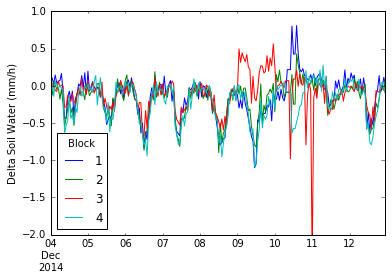

In [45]:
WaterUseHourly.ix['2014-12-04':'2014-12-12',('High','Omaka')].plot()
plt.ylabel('Delta Soil Water (mm/h)')
plt.ylim(-2,1)

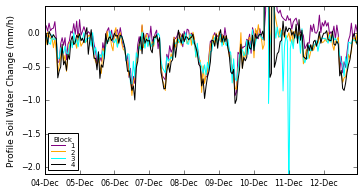

In [100]:
data = WaterDeltaHourly.ix['2014-12-04':'2014-12-12',('High','Omaka')]
BlockColors = ['purple','orange','cyan','k']
fig, ax = plt.subplots(figsize=(5.6,3))
BlockPos = 0
for b in data.columns:
    Ind = data.ix[:,b].index
    Med = data.ix[:,b]
    plt.plot(Ind,Med,'-',color = BlockColors[BlockPos],label = b)
    BlockPos+=1

plt.ylabel('Profile Soil Water Change (mm/h)',fontsize=9)
ax.xaxis.set_major_locator(mdates.HourLocator(0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.tick_params(labelsize=8)
plt.ylim(-2.1,0.4)

ledg = plt.legend(loc=3,numpoints=1,fontsize = 7,labelspacing = 0.05, 
                          title='Block')
ledg.get_title().set_fontsize(7)
plt.savefig('Fig_$.jpg',dpi=1000)

In [81]:
data.ix[:,]

IndexError: index 4 is out of bounds for axis 0 with size 4

In [63]:
fig, ax = plt.subplots(figsize=(5.6,3))
plt.plot(WaterDeltaHourly.ix['2014-12-04':'2014-12-12',('High','Omaka')])
plt.ylabel('Profile Soil Water Change (mm/h)',fontsize=9)
ax.xaxis.set_major_locator(mdates.DateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y %H:%M'))
plt.tick_params(labelsize=8)
plt.ylim(-2,1)

#ledg = plt.legend(loc=4,numpoints=1,fontsize = 7,labelspacing = 0.05, 
#                          title='Cultivar by Irrigation')
#ledg.get_title().set_fontsize(7)
#plt.savefig('Fig_*.jpg',dpi=1000)

(-2, 1)

Error in callback <function post_execute at 0x00000000093A5C18> (for post_execute):


NotImplementedError: Derived must override

In [47]:
WaterUseDaily.ix[:,('High','Dash')].mean(axis=1)

Date
2014-11-05    -0.618750
2014-11-06    -0.907500
2014-11-07     0.419994
2014-11-08    -0.605461
2014-11-09    -1.335224
2014-11-10    -1.810098
2014-11-11          NaN
2014-11-12     0.107693
2014-11-13    -2.160826
2014-11-14    -2.033364
2014-11-15    -2.472803
2014-11-16    -1.966994
2014-11-17    -3.863064
2014-11-18          NaN
2014-11-19    -4.445023
2014-11-20    -4.616719
2014-11-21    -6.079937
2014-11-22    -4.946078
2014-11-23    -5.777900
2014-11-24    -7.733785
2014-11-25    -5.245813
2014-11-26          NaN
2014-11-27    -5.869292
2014-11-28    -1.103616
2014-11-29    -5.230205
2014-11-30    -4.309943
2014-12-01    -5.916141
2014-12-02          NaN
2014-12-03    -3.068931
2014-12-04    -2.861365
                ...    
2015-01-13    -6.087397
2015-01-14          NaN
2015-01-15    -5.427770
2015-01-16    -8.625015
2015-01-17   -10.614672
2015-01-18   -12.760441
2015-01-19   -11.137571
2015-01-20    -5.545434
2015-01-21    -2.967146
2015-01-22    -6.159259
2015-01-23 

In [48]:
WaterUseDaily.ix[:,('High','Dash')].std(axis=1)/np.sqrt(4)

Date
2014-11-05    0.091983
2014-11-06    0.148018
2014-11-07    0.194090
2014-11-08    0.395286
2014-11-09    0.322929
2014-11-10    0.367592
2014-11-11         NaN
2014-11-12    0.494601
2014-11-13    0.236585
2014-11-14    0.186414
2014-11-15    0.241184
2014-11-16    0.141687
2014-11-17    1.220703
2014-11-18         NaN
2014-11-19    0.595551
2014-11-20    0.271604
2014-11-21    0.277623
2014-11-22    0.346086
2014-11-23    0.605077
2014-11-24    0.444378
2014-11-25    0.840260
2014-11-26         NaN
2014-11-27    0.371849
2014-11-28    0.191500
2014-11-29    0.493809
2014-11-30    0.320668
2014-12-01    1.432400
2014-12-02         NaN
2014-12-03    0.681418
2014-12-04    0.100735
                ...   
2015-01-13    1.385366
2015-01-14         NaN
2015-01-15    0.409474
2015-01-16    0.723575
2015-01-17    0.927177
2015-01-18    1.939214
2015-01-19    2.167687
2015-01-20    0.837109
2015-01-21    0.487041
2015-01-22    0.972503
2015-01-23    0.995645
2015-01-24    0.679460
2015-0

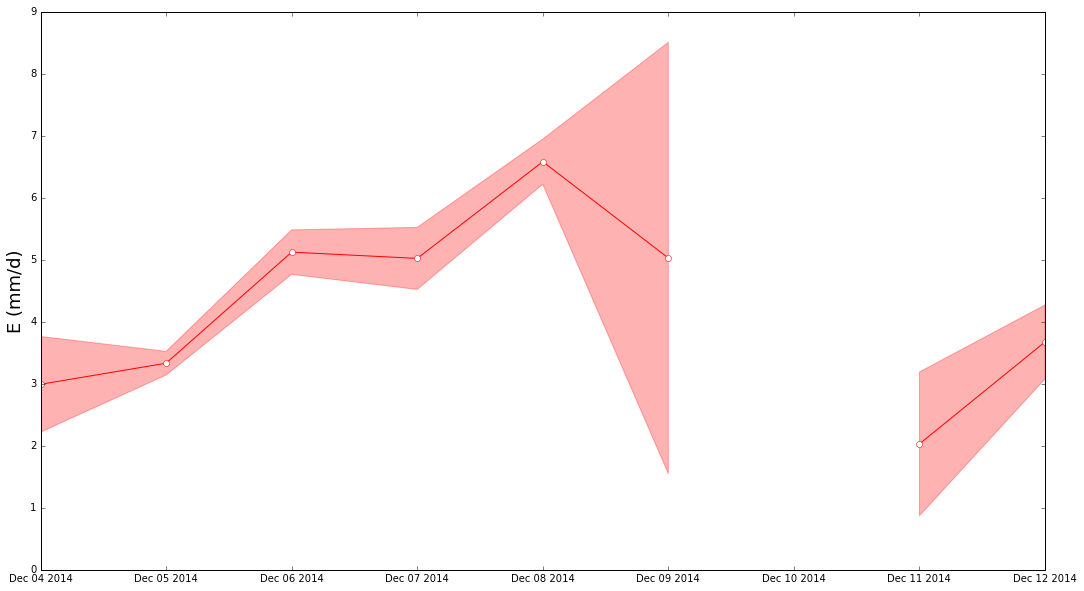

In [49]:
fig = plt.figure(figsize=(18,10))
CulPos = 0
for Cul in ['Omaka']:
    IrrPos = 0
    for Irr in ['High']:
        Ind = WaterUseDaily.ix['2014-12-04':'2014-12-12',(Irr,Cul)].index
        Med = WaterUseDaily.ix['2014-12-04':'2014-12-12',(Irr,Cul)].mean(axis=1)*-1
        SEM = WaterUseDaily.ix['2014-12-04':'2014-12-12',(Irr,Cul)].std(axis=1)/np.sqrt(4)
        Upp = Med + SEM
        Low = Med - SEM
        plt.fill_between(Ind,Upp,Low,color = irrigColors[IrrPos],alpha=0.3)
        plt.plot(Ind,Med,'o-',mec=irrigColors[IrrPos], mfc = cultColors[CulPos],label = Cul + ' ' + Irr,color=irrigColors[IrrPos])
        IrrPos += 1
        CulPos+=1
        
plt.ylabel('E (mm/d)',fontsize=18)
